In [21]:
# Package imports
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_circles, make_moons, make_blobs
import sklearn.linear_model
from sklearn.preprocessing import StandardScaler

#from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
# https://www.kaggle.com/code/kolisnehar/planar-utils
# https://planar-utils.readthedocs.io/_/downloads/en/latest/pdf/

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():
    N = 200
    noisy_circles = make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = make_moons(n_samples=N, noise=.2)
    blobs = make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)

    return noisy_circles, noisy_moons, blobs



The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


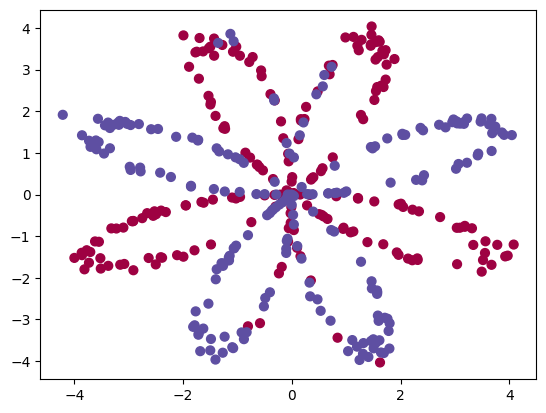

In [22]:
# Load dataset
X, Y = load_planar_dataset()

# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))


In [ ]:
X

In [24]:
Y

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [26]:
# definimos cantidad de capas: layer_sizes
# https://qastack.mx/stats/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

def layer_sizes(X, Y, n_h):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """

    n_x = X.shape[0]
    #n_h = 4            # asignamos cantidad de nodos ocultos = 4
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

(n_x, n_h, n_y) = layer_sizes(X, Y, 4)    # sin overcodeo ;)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))


The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


In [9]:
# initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y,1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


np.random.seed(2)
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


In [ ]:
# forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']


    # Implement Forward Propagation to calculate A2 (probabilities)

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

A2, cache = forward_propagation(X, parameters)
print("A2 = " + str(A2))


In [ ]:
A2

In [28]:
A2.shape

(1, 400)

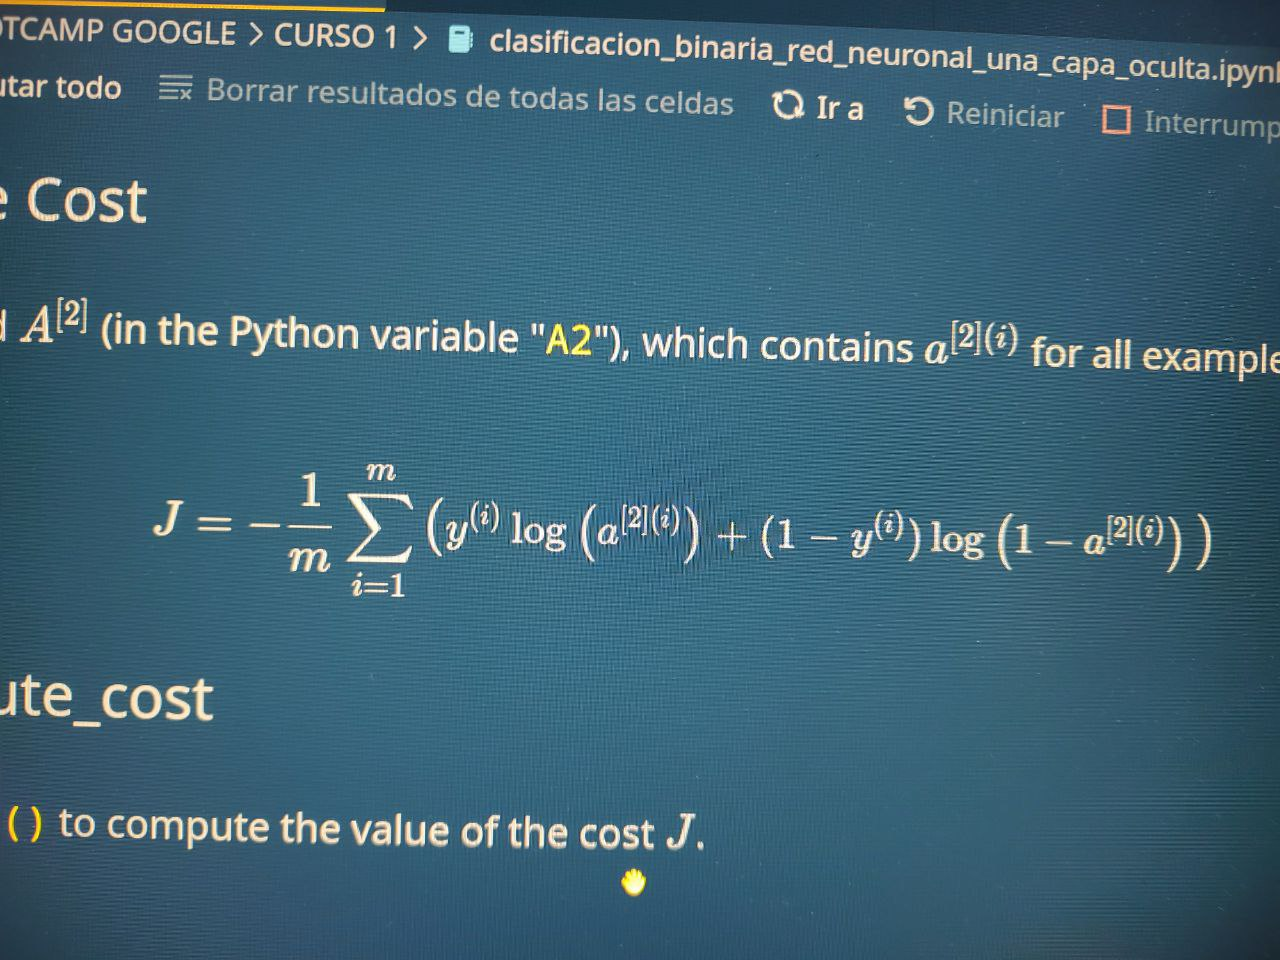

In [29]:
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/0
# compute_cost

def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)

    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)

    """

    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost

    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),(1-Y))
    cost = - np.sum(logprobs) / m

    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect.
                                    # E.g., turns [[17]] into 17

    return cost


cost = compute_cost(A2, Y)
print("cost = " + str(compute_cost(A2, Y)))


cost = 2.933711032624795


In [30]:
# backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    # First, retrieve W1 and W2 from the dictionary "parameters".

    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']

    # Retrieve also A1 and A2 from dictionary "cache".

    A1 = cache['A1']
    A2 = cache['A2']


    # Backward propagation: calculate dW1, db1, dW2, db2.

    dZ2 = A2 -Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)
    Z1 = np.dot(W1, X) + b1
    th_z1 = np.tanh(Z1)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(th_z1,2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads


grads = backward_propagation(parameters, cache, X, Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))


dW1 = [[-8.37885107e-02  3.93565207e-03]
 [-9.77279818e-01 -3.90490284e-01]
 [-6.98315734e-04  1.32446477e-03]
 [-3.04795122e-03  2.30464173e-03]
 [ 3.91661082e-04 -8.60327455e-04]
 [ 4.83905812e-04 -1.01741146e-03]
 [ 1.86778049e-04 -4.37768645e-04]
 [-2.86372120e-04  6.57340641e-04]
 [-2.52681470e-04  5.86245845e-04]
 [-6.72647525e-04  1.29132230e-03]
 [-1.99957889e-04  4.68466356e-04]
 [ 7.82681510e-04 -1.42746367e-03]
 [-1.74600519e-04  4.08985640e-04]
 [ 3.75582095e-04 -8.31078948e-04]
 [-2.07832047e-04  4.86565409e-04]
 [ 1.48151166e-02 -1.06723679e-02]
 [-2.87180440e-03  2.35959338e-03]
 [-7.49485975e-02  5.82836096e-02]
 [ 3.12598271e-03 -2.29483258e-03]
 [-6.61308452e-02  2.36426244e-02]
 [-6.56379591e-04  1.26987559e-03]
 [-2.89806648e-04  6.64409293e-04]
 [-2.36965422e-04  5.51974944e-04]
 [-1.12323629e-03  1.76707401e-03]
 [-2.97274762e-04  6.79683822e-04]
 [ 1.73879248e-04 -4.07267127e-04]
 [ 1.81698569e-04 -4.25817092e-04]
 [-8.05186503e-04  1.45347367e-03]
 [ 1.94478890e

In [31]:
# update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    # Retrieve a copy of each parameter from the dictionary "parameters". Use copy.deepcopy(...) for W1 and W2

    W1 = copy.deepcopy(parameters['W1'])
    b1 = parameters['b1']
    W2 = copy.deepcopy(parameters['W2'])
    b2 = parameters['b2']

    # Retrieve each gradient from the dictionary "grads"

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    # Update rule for each parameter

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


W1 = [[ 6.07602605e+00  6.07757705e+00]
 [ 1.12302870e+00  1.55234443e-01]
 [-5.15206631e-02 -2.94358997e-01]
 [-1.07704577e-01 -1.89506555e-01]
 [ 3.05644426e-02  3.35691261e-01]
 [ 3.85704246e-02  3.20187777e-01]
 [-3.54794151e-03  3.93034391e-01]
 [-1.75277635e-02 -3.59410444e-01]
 [-1.18025997e-02 -3.69124027e-01]
 [-5.02327919e-02 -2.96934315e-01]
 [-1.22129459e-04 -3.87589285e-01]
 [ 5.54125322e-02  2.86597423e-01]
 [ 7.29854846e-03 -3.98445576e-01]
 [ 2.89108963e-02  3.38815599e-01]
 [-2.14396066e-03 -3.84516638e-01]
 [-5.85449156e-01  5.55058664e-01]
 [-1.04415577e-01 -1.96424434e-01]
 [ 8.00047664e-01 -8.04752535e-01]
 [ 1.11565401e-01  1.88134037e-01]
 [ 1.79981730e+00  2.24687430e+00]
 [-4.93911152e-02 -2.98626935e-01]
 [-1.80555282e-02 -3.58491495e-01]
 [-8.72896347e-03 -3.74153021e-01]
 [-6.76297502e-02 -2.62716493e-01]
 [-1.91764967e-02 -3.56535717e-01]
 [-7.53350689e-03  3.98778445e-01]
 [-5.06418408e-03  3.95245061e-01]
 [-5.63710940e-02 -2.84684998e-01]
 [ 1.39896536e+

In [32]:
# nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y, n_h)[0]
    n_y = layer_sizes(X, Y, n_h)[2]

    # Initialize parameters

    parameters = initialize_parameters(n_x, n_h, n_y)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".

        # Cost function. Inputs: "A2, Y". Outputs: "cost".

        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".

        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".

        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

# predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.

    A2, cache = forward_propagation(X, parameters)
    predictions = np.where(A2 > 0.5, 1, 0)

    return predictions


predictions = predict(parameters, X)
print("Predictions: " + str(predictions))


Predictions: [[0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1
  0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 0]]


Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220648
Cost after iteration 8000: 0.219405
Cost after iteration 9000: 0.218484


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

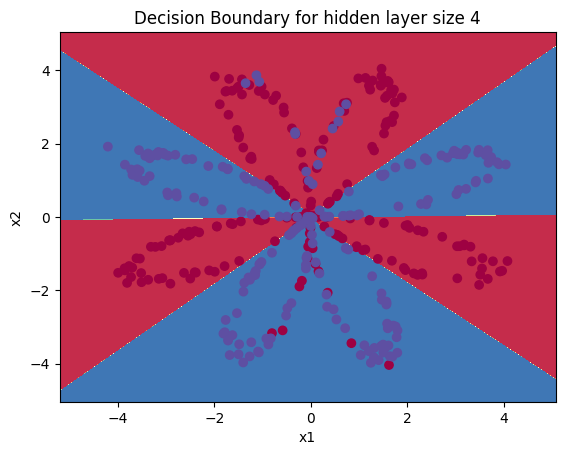

In [33]:
# AHORA SÍ ARMAMOS NUESTRA RED NEURONAL

# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))


Accuracy: 90%
[[184  16]
 [ 21 179]]


<Figure size 640x480 with 0 Axes>

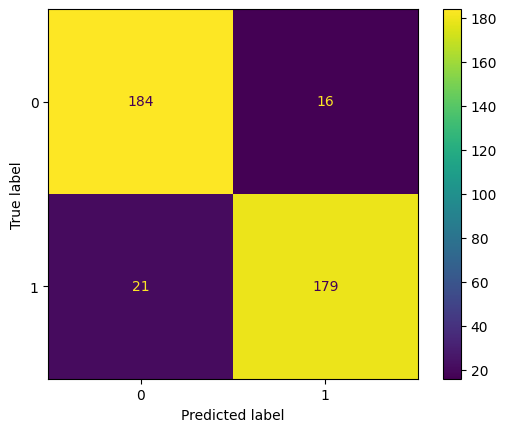

In [34]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

#  vemos la matriz de confusión

def matriz_confusion(y_test, y_pred):
    '''Generamos la matriz de confusión para el ajuste del modelo'''

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.figure()
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    plt.close()


matriz_confusion(Y.flatten(), predictions.flatten())
# con .flatten() pasamos un array de numpy que es una matriz de 1 columna o fila
# a un array lineal (tipo vector)

# vemos que tiene 184 aciertos (son 0 y predice 0) más 179 aciertos (son 1 y
# predice 1) y 21 + 16 fallos ( son 1 y predice 0, ó, son 0 y predice 1, respectivamente)

# estos valores pueden variar cada vez que se la entrene

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 91.0 %
Accuracy for 50 hidden units: 90.25 %


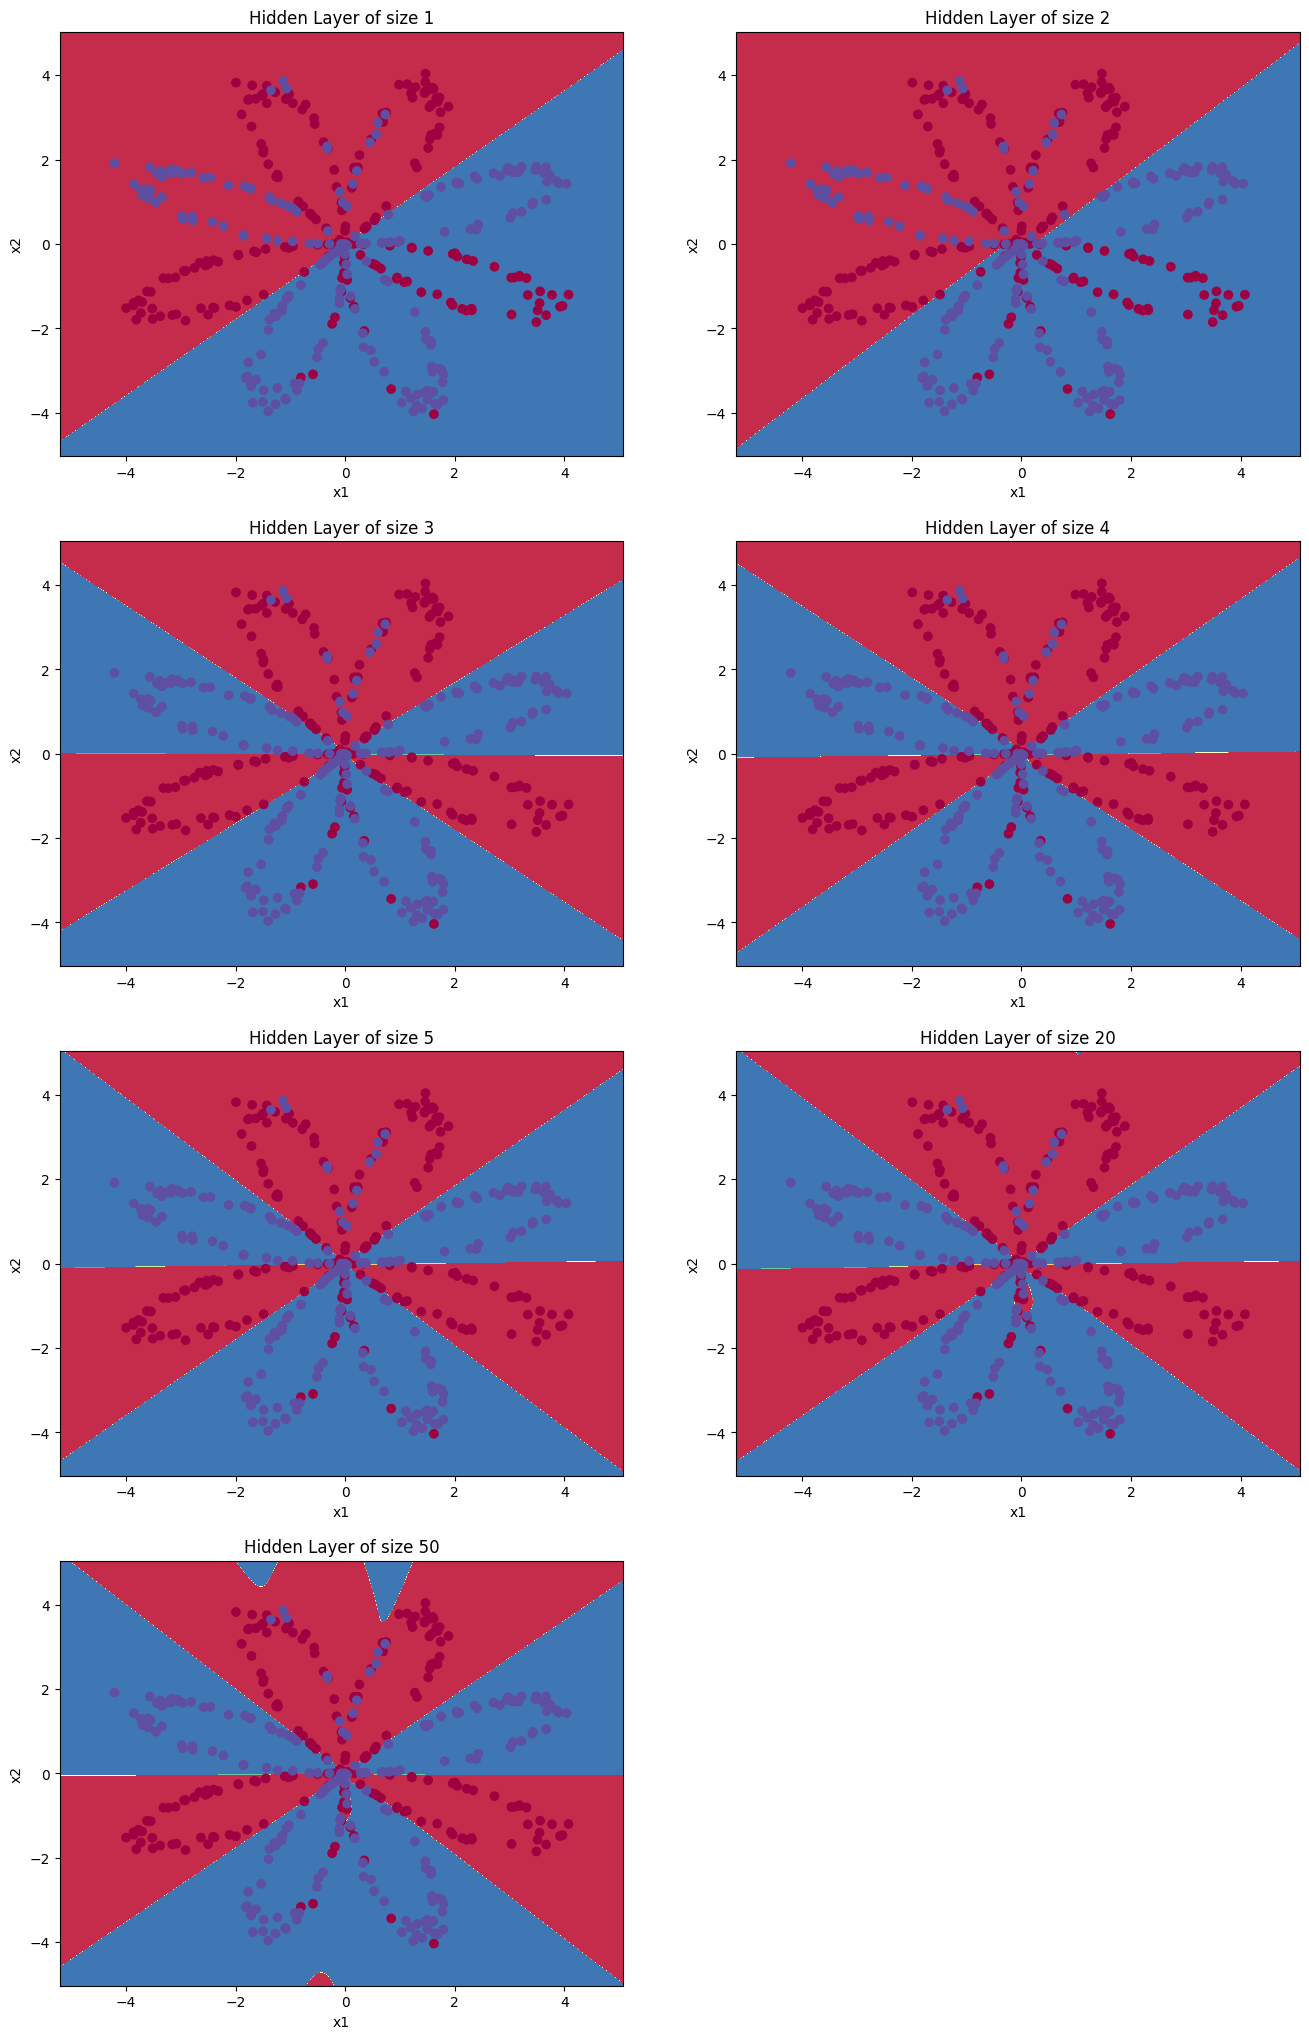

In [35]:
#%%    CAMBIAMOS LA CANTIDAD DE UNIDADES DE LA CAPA OCULTA

# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))


Dataset: noisy_circles
(200,)


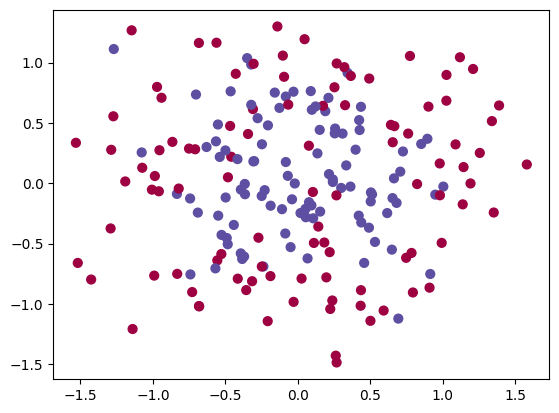

Cost after iteration 0: 0.693147
Cost after iteration 1000: 0.637718
Cost after iteration 2000: 0.634965
Cost after iteration 3000: 0.633193
Cost after iteration 4000: 0.632086
Cost after iteration 5000: 0.631311
Cost after iteration 6000: 0.630734
Cost after iteration 7000: 0.630287
Cost after iteration 8000: 0.629929
Cost after iteration 9000: 0.629637


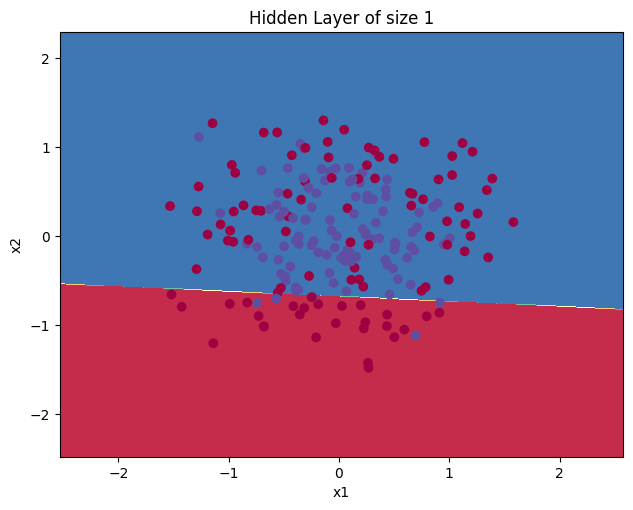

[[27 73]
 [ 5 95]]


<Figure size 640x480 with 0 Axes>

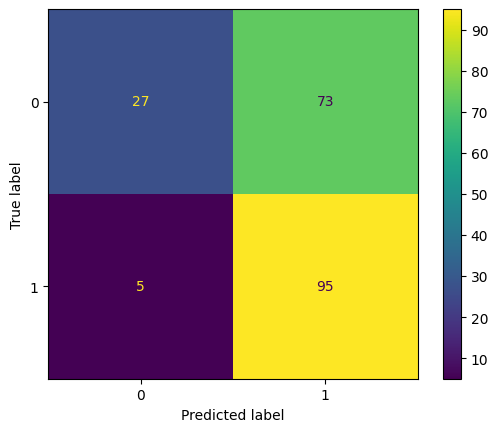

Accuracy for 1 hidden units: 61.0 %
Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.556972
Cost after iteration 2000: 0.553909
Cost after iteration 3000: 0.552968
Cost after iteration 4000: 0.552347
Cost after iteration 5000: 0.551869
Cost after iteration 6000: 0.551480
Cost after iteration 7000: 0.551155
Cost after iteration 8000: 0.550882
Cost after iteration 9000: 0.550649


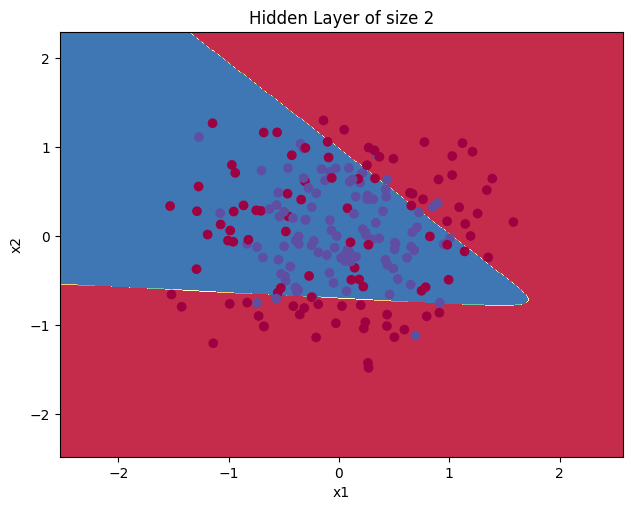

[[52 48]
 [ 8 92]]


<Figure size 640x480 with 0 Axes>

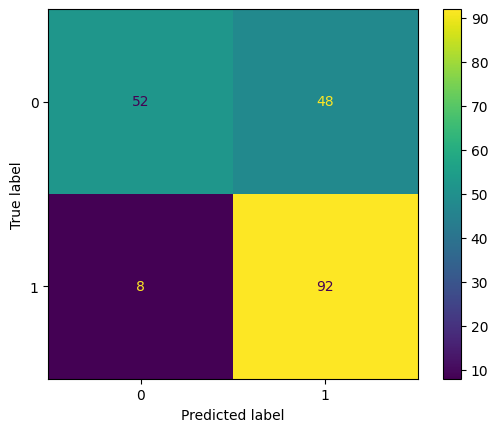

Accuracy for 2 hidden units: 72.0 %
Cost after iteration 0: 0.693145
Cost after iteration 1000: 0.452968
Cost after iteration 2000: 0.452650
Cost after iteration 3000: 0.452595
Cost after iteration 4000: 0.452580
Cost after iteration 5000: 0.452574
Cost after iteration 6000: 0.452573
Cost after iteration 7000: 0.452572
Cost after iteration 8000: 0.452572
Cost after iteration 9000: 0.452572


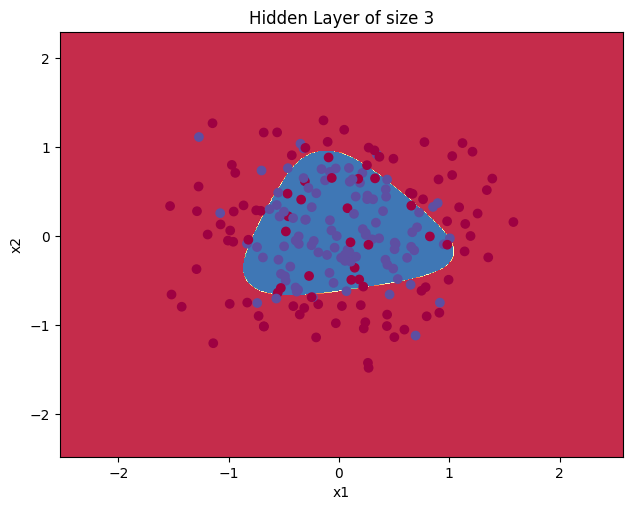

[[78 22]
 [20 80]]


<Figure size 640x480 with 0 Axes>

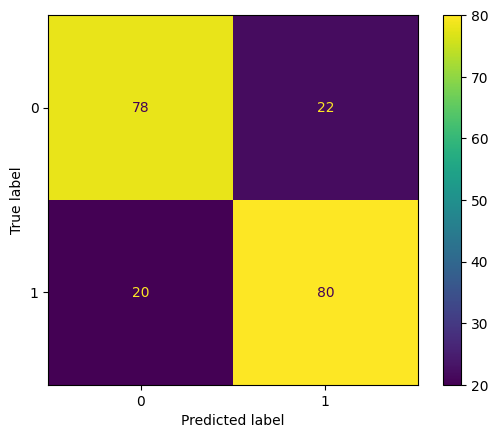

Accuracy for 3 hidden units: 79.0 %
Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.451125
Cost after iteration 2000: 0.447725
Cost after iteration 3000: 0.446440
Cost after iteration 4000: 0.448331
Cost after iteration 5000: 0.448100
Cost after iteration 6000: 0.447719
Cost after iteration 7000: 0.447083
Cost after iteration 8000: 0.446550
Cost after iteration 9000: 0.446136


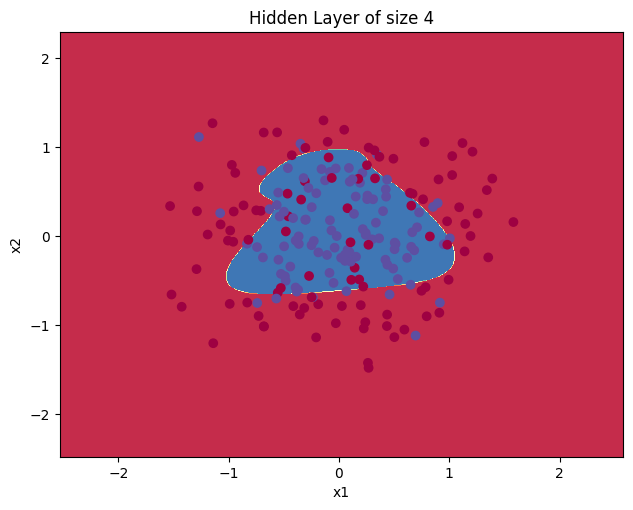

[[77 23]
 [19 81]]


<Figure size 640x480 with 0 Axes>

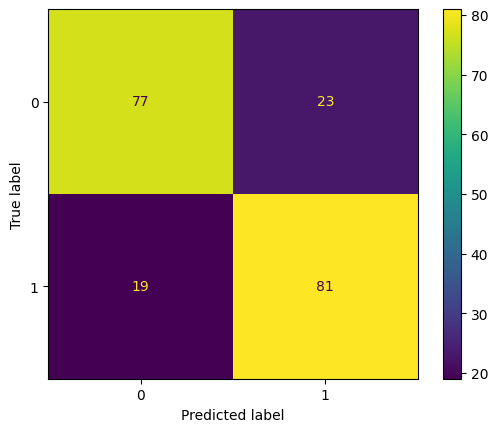

Accuracy for 4 hidden units: 79.0 %
Cost after iteration 0: 0.693152
Cost after iteration 1000: 0.457227
Cost after iteration 2000: 0.454240
Cost after iteration 3000: 0.437348
Cost after iteration 4000: 0.430125
Cost after iteration 5000: 0.422732
Cost after iteration 6000: 0.418166
Cost after iteration 7000: 0.415304
Cost after iteration 8000: 0.413334
Cost after iteration 9000: 0.411871


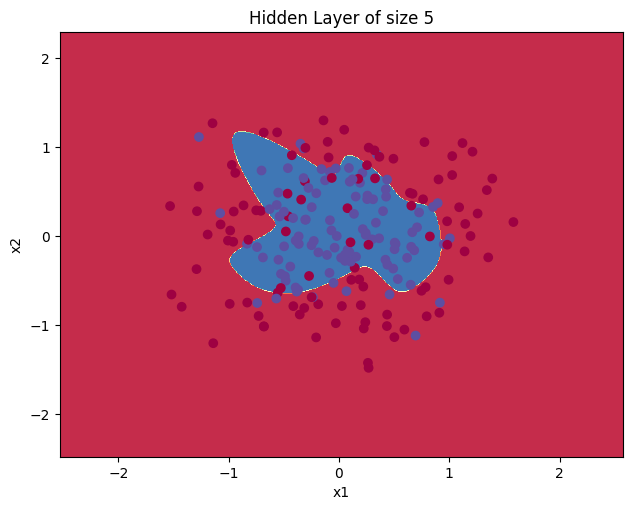

[[82 18]
 [22 78]]


<Figure size 640x480 with 0 Axes>

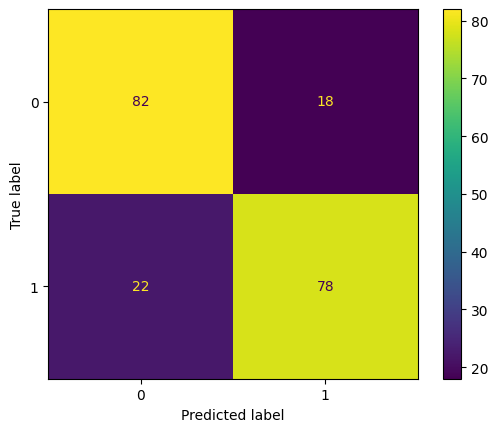

Accuracy for 5 hidden units: 80.0 %
Cost after iteration 0: 0.693143
Cost after iteration 1000: 0.491467
Cost after iteration 2000: 0.434849
Cost after iteration 3000: 0.416514
Cost after iteration 4000: 0.413514
Cost after iteration 5000: 0.401901
Cost after iteration 6000: 0.393959
Cost after iteration 7000: 0.388732
Cost after iteration 8000: 0.385583
Cost after iteration 9000: 0.383384


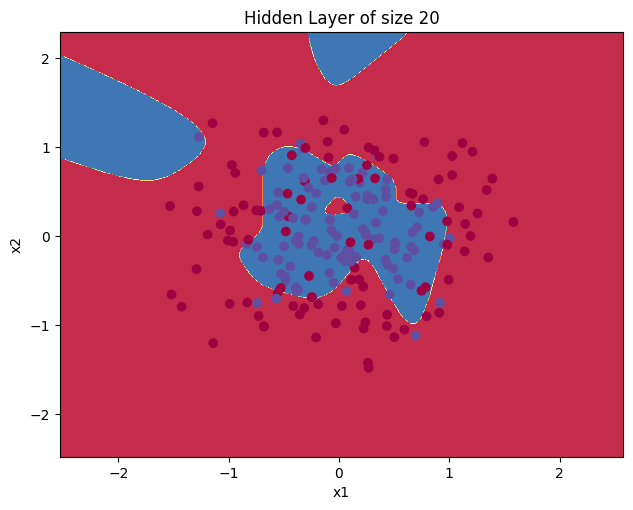

[[81 19]
 [14 86]]


<Figure size 640x480 with 0 Axes>

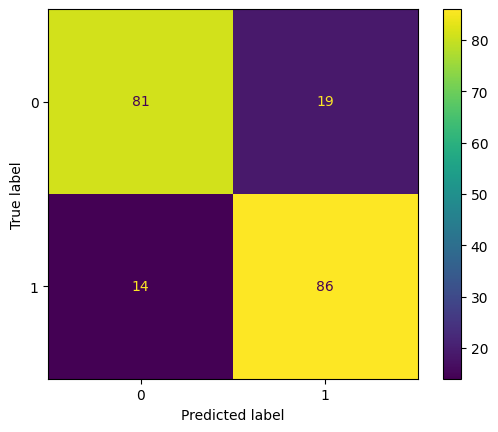

Accuracy for 20 hidden units: 83.5 %
Cost after iteration 0: 0.693143
Cost after iteration 1000: 0.586604
Cost after iteration 2000: 0.452519
Cost after iteration 3000: 0.444510
Cost after iteration 4000: 0.440731
Cost after iteration 5000: 0.437772
Cost after iteration 6000: 0.429899
Cost after iteration 7000: 0.421280
Cost after iteration 8000: 0.400977
Cost after iteration 9000: 0.390172


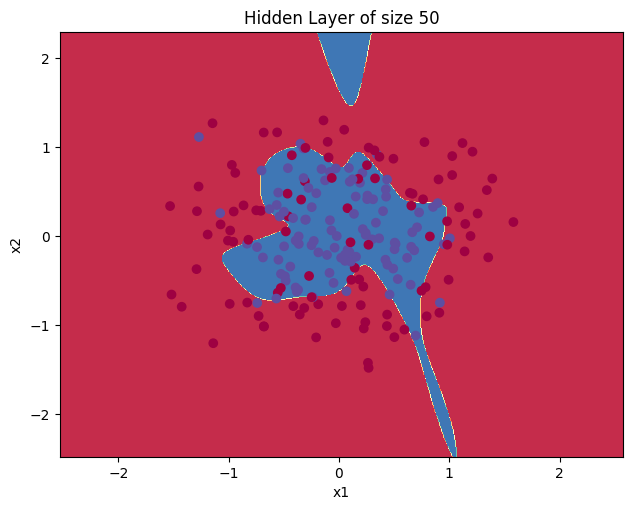

[[81 19]
 [14 86]]


<Figure size 640x480 with 0 Axes>

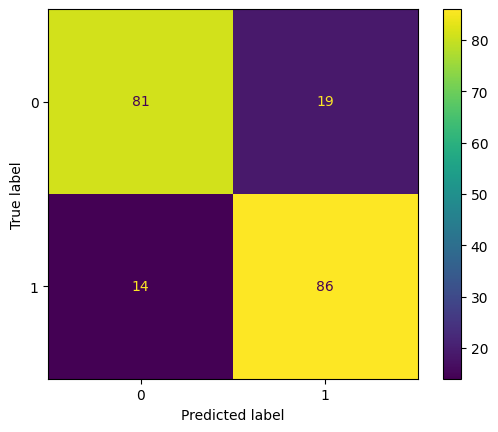

Accuracy for 50 hidden units: 83.5 %
Dataset: noisy_moons
(200,)


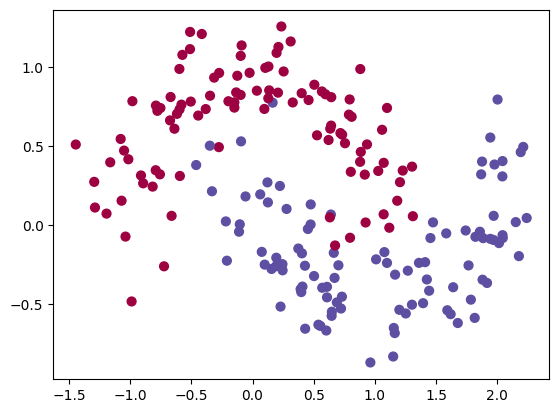

Cost after iteration 0: 0.693144
Cost after iteration 1000: 0.305191
Cost after iteration 2000: 0.305197
Cost after iteration 3000: 0.305197
Cost after iteration 4000: 0.305197
Cost after iteration 5000: 0.305197
Cost after iteration 6000: 0.305197
Cost after iteration 7000: 0.305197
Cost after iteration 8000: 0.305197
Cost after iteration 9000: 0.305197


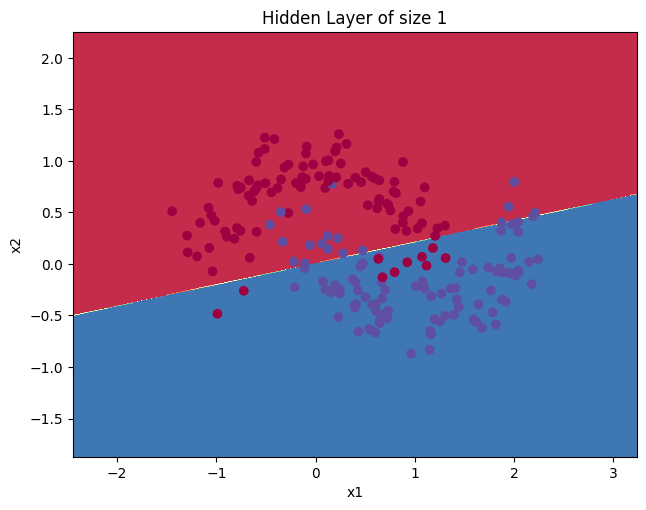

[[90 10]
 [19 81]]


<Figure size 640x480 with 0 Axes>

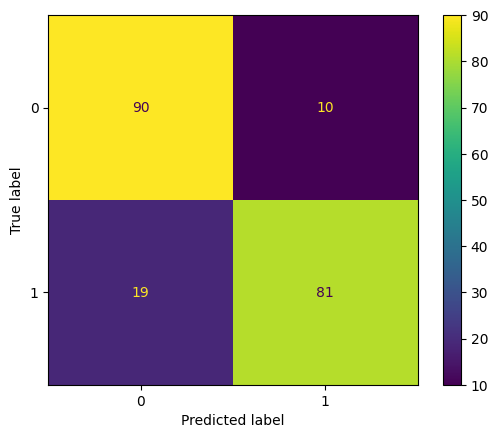

Accuracy for 1 hidden units: 85.5 %
Cost after iteration 0: 0.693171
Cost after iteration 1000: 0.275740
Cost after iteration 2000: 0.271732
Cost after iteration 3000: 0.269374
Cost after iteration 4000: 0.267909
Cost after iteration 5000: 0.266919
Cost after iteration 6000: 0.266193
Cost after iteration 7000: 0.265628
Cost after iteration 8000: 0.265167
Cost after iteration 9000: 0.264780


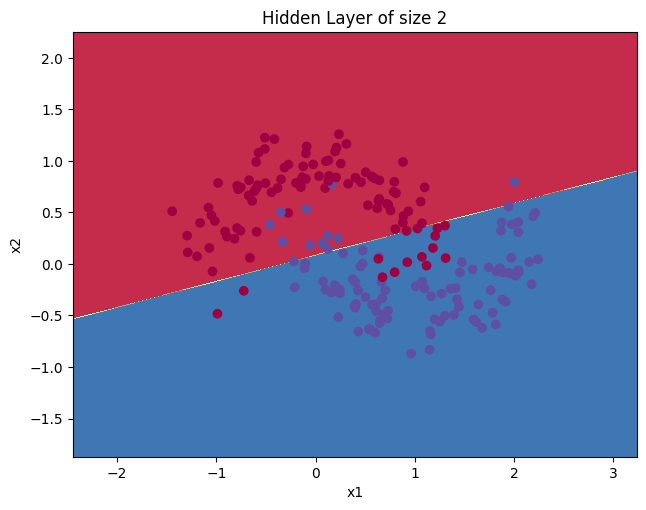

[[87 13]
 [11 89]]


<Figure size 640x480 with 0 Axes>

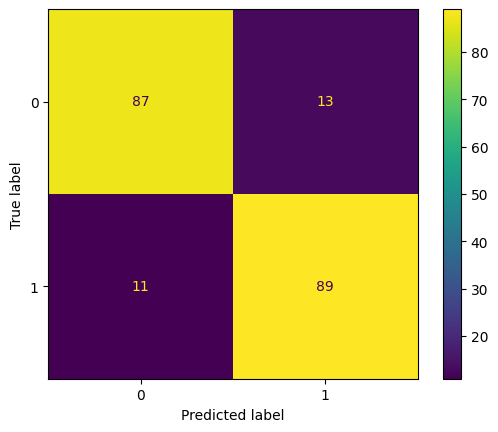

Accuracy for 2 hidden units: 88.0 %
Cost after iteration 0: 0.693174
Cost after iteration 1000: 0.088027
Cost after iteration 2000: 0.071646
Cost after iteration 3000: 0.068258
Cost after iteration 4000: 0.066539
Cost after iteration 5000: 0.069861
Cost after iteration 6000: 0.071219
Cost after iteration 7000: 0.071815
Cost after iteration 8000: 0.072073
Cost after iteration 9000: 0.072182


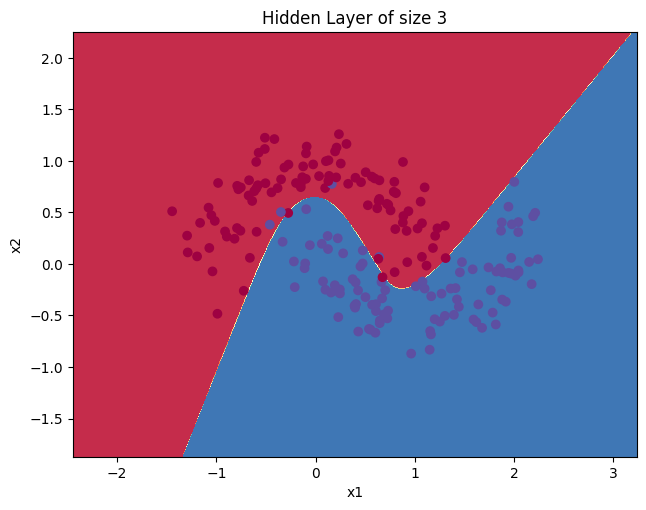

[[98  2]
 [ 4 96]]


<Figure size 640x480 with 0 Axes>

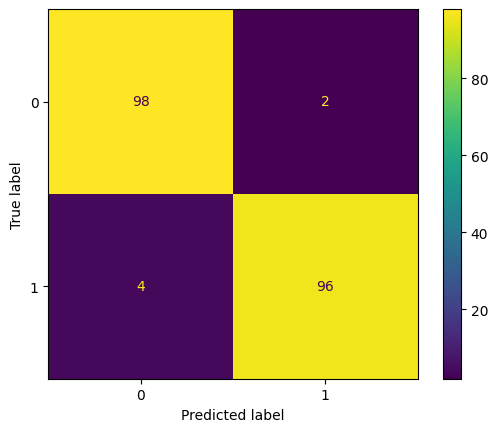

Accuracy for 3 hidden units: 97.0 %
Cost after iteration 0: 0.693158
Cost after iteration 1000: 0.152031
Cost after iteration 2000: 0.070345
Cost after iteration 3000: 0.062862
Cost after iteration 4000: 0.059163
Cost after iteration 5000: 0.062127
Cost after iteration 6000: 0.060071
Cost after iteration 7000: 0.057960
Cost after iteration 8000: 0.056861
Cost after iteration 9000: 0.056176


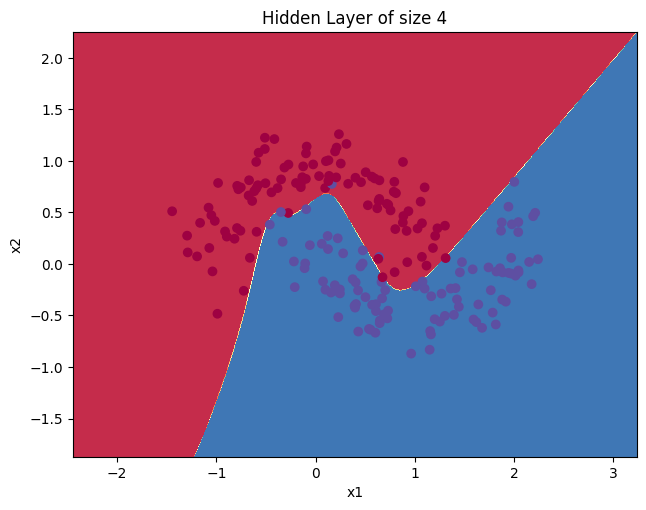

[[98  2]
 [ 3 97]]


<Figure size 640x480 with 0 Axes>

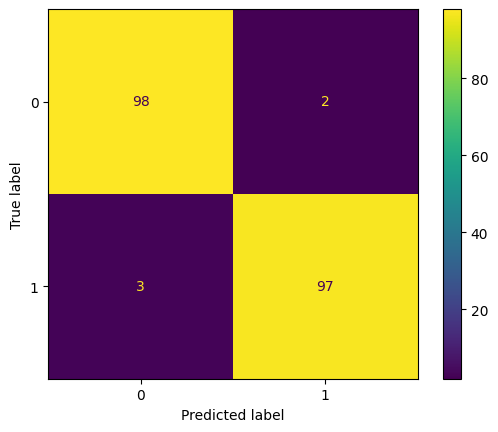

Accuracy for 4 hidden units: 97.5 %
Cost after iteration 0: 0.693143
Cost after iteration 1000: 0.103078
Cost after iteration 2000: 0.070855
Cost after iteration 3000: 0.059242
Cost after iteration 4000: 0.054258
Cost after iteration 5000: 0.050205
Cost after iteration 6000: 0.044205
Cost after iteration 7000: 0.042379
Cost after iteration 8000: 0.040624
Cost after iteration 9000: 0.039567


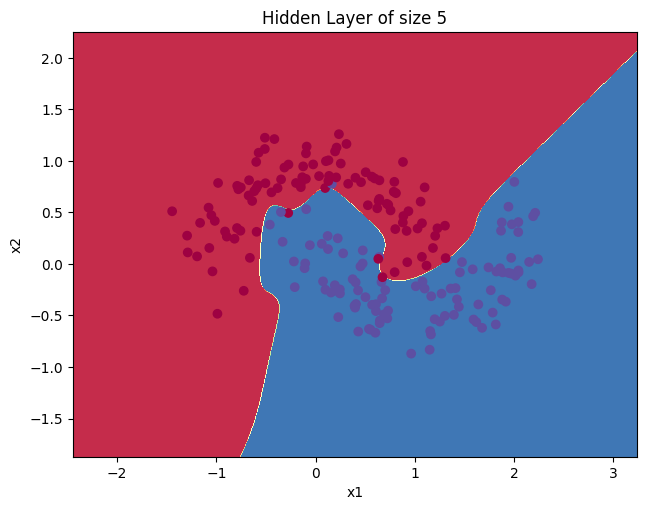

[[97  3]
 [ 1 99]]


<Figure size 640x480 with 0 Axes>

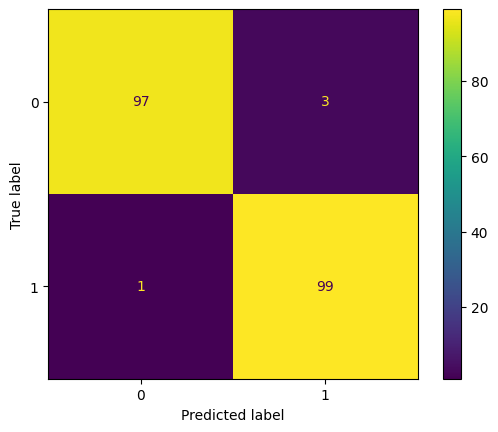

Accuracy for 5 hidden units: 98.0 %
Cost after iteration 0: 0.693324
Cost after iteration 1000: 0.287285
Cost after iteration 2000: 0.113515
Cost after iteration 3000: 0.085007
Cost after iteration 4000: 0.082192
Cost after iteration 5000: 0.076828
Cost after iteration 6000: 0.067530
Cost after iteration 7000: 0.058489
Cost after iteration 8000: 0.050494
Cost after iteration 9000: 0.045238


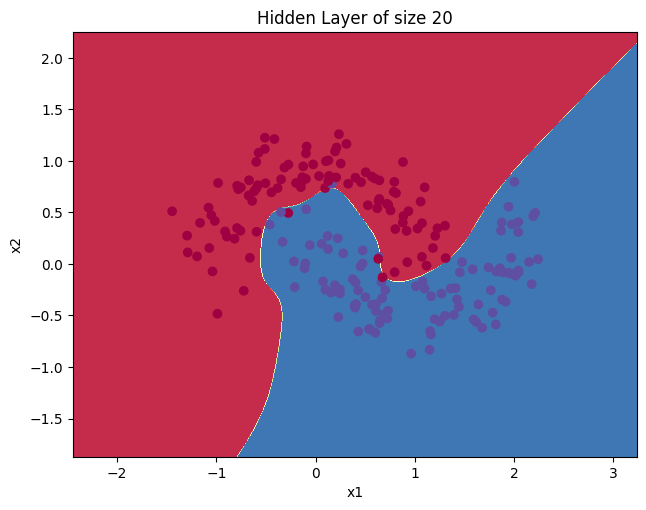

[[97  3]
 [ 1 99]]


<Figure size 640x480 with 0 Axes>

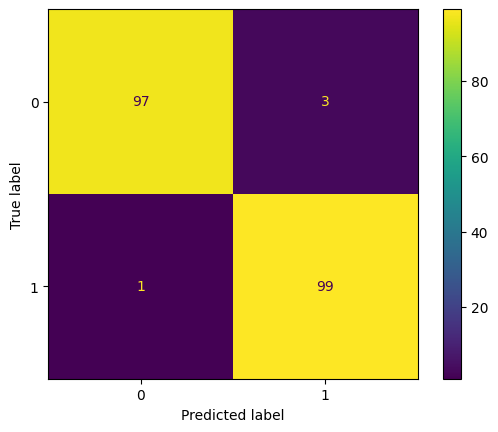

Accuracy for 20 hidden units: 98.0 %
Cost after iteration 0: 0.692929
Cost after iteration 1000: 0.098330
Cost after iteration 2000: 0.089996
Cost after iteration 3000: 0.092981
Cost after iteration 4000: 0.088059
Cost after iteration 5000: 0.080095
Cost after iteration 6000: 0.085010
Cost after iteration 7000: 0.074885
Cost after iteration 8000: 0.072269
Cost after iteration 9000: 0.070349


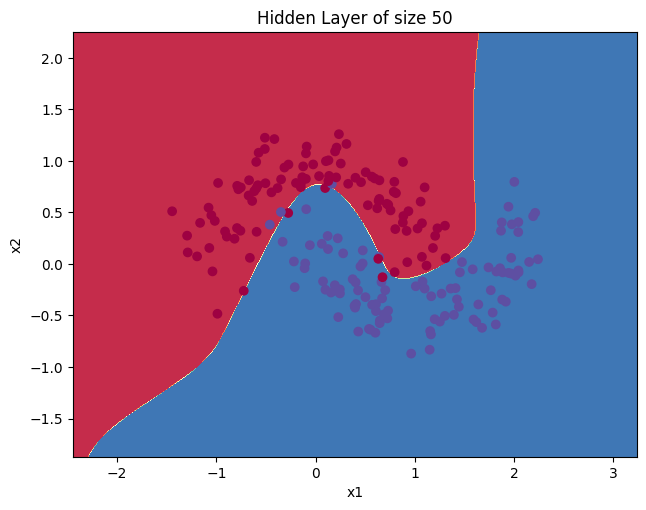

[[96  4]
 [ 3 97]]


<Figure size 640x480 with 0 Axes>

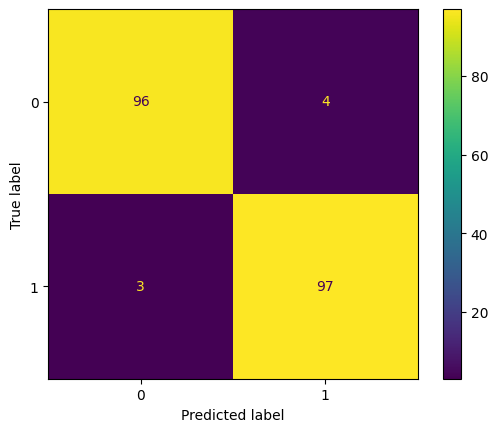

Accuracy for 50 hidden units: 96.5 %
Dataset: blobs
(200,)


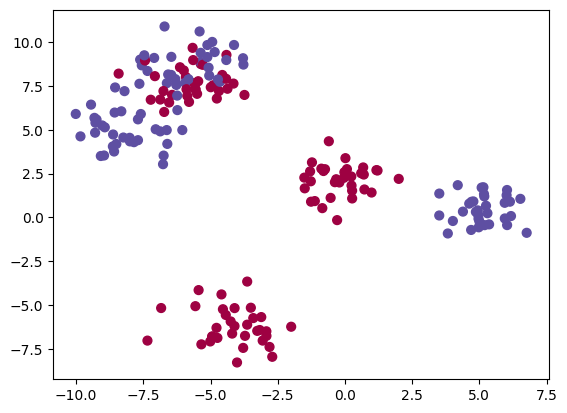

Cost after iteration 0: 0.693142
Cost after iteration 1000: 0.557157
Cost after iteration 2000: 0.556635
Cost after iteration 3000: 0.556376
Cost after iteration 4000: 0.556184
Cost after iteration 5000: 0.556018
Cost after iteration 6000: 0.555866
Cost after iteration 7000: 0.555723
Cost after iteration 8000: 0.555587
Cost after iteration 9000: 0.555458


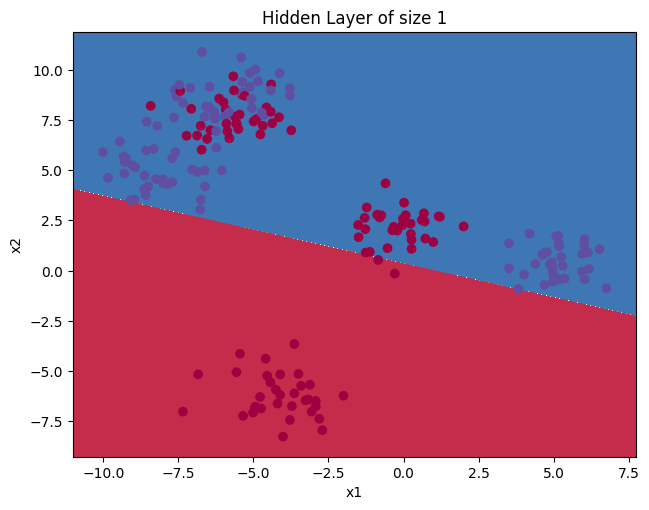

[[35 65]
 [ 1 99]]


<Figure size 640x480 with 0 Axes>

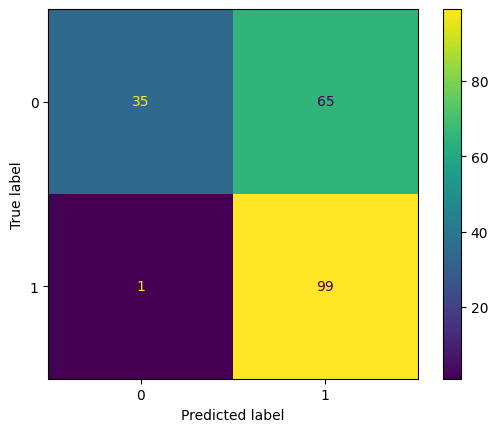

Accuracy for 1 hidden units: 67.0 %
Cost after iteration 0: 0.693106
Cost after iteration 1000: 0.557357
Cost after iteration 2000: 0.556793
Cost after iteration 3000: 0.556534
Cost after iteration 4000: 0.556350
Cost after iteration 5000: 0.556195
Cost after iteration 6000: 0.556052
Cost after iteration 7000: 0.555917
Cost after iteration 8000: 0.555785
Cost after iteration 9000: 0.555657


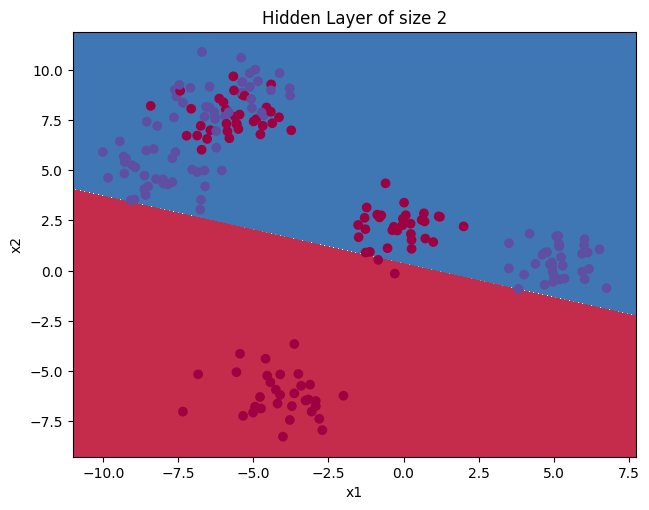

[[35 65]
 [ 1 99]]


<Figure size 640x480 with 0 Axes>

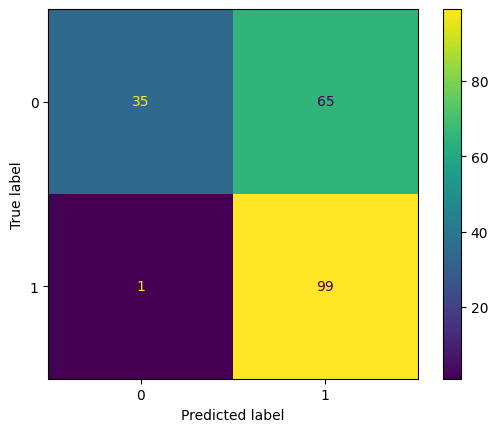

Accuracy for 2 hidden units: 67.0 %
Cost after iteration 0: 0.693052
Cost after iteration 1000: 0.323507
Cost after iteration 2000: 0.323243
Cost after iteration 3000: 0.322942
Cost after iteration 4000: 0.322716
Cost after iteration 5000: 0.322808
Cost after iteration 6000: 0.323036
Cost after iteration 7000: 0.322746
Cost after iteration 8000: 0.322739
Cost after iteration 9000: 0.322700


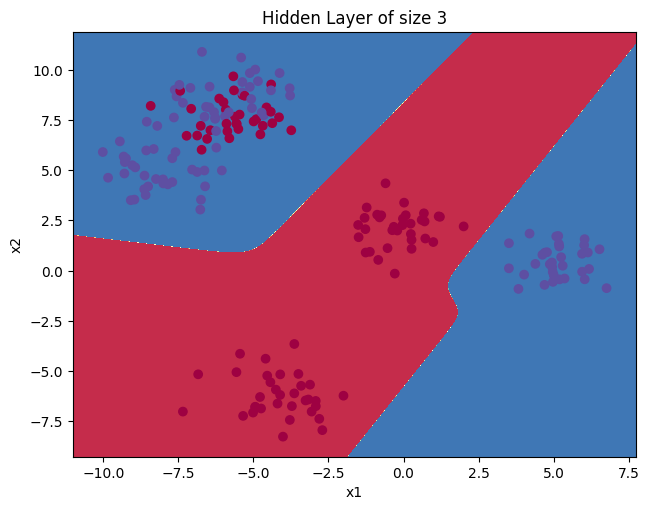

[[ 66  34]
 [  0 100]]


<Figure size 640x480 with 0 Axes>

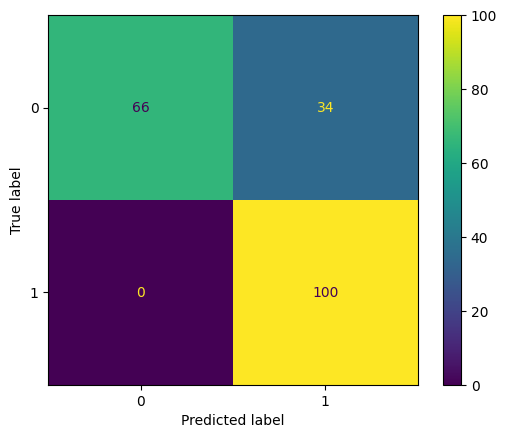

Accuracy for 3 hidden units: 83.0 %
Cost after iteration 0: 0.693080
Cost after iteration 1000: 0.323760
Cost after iteration 2000: 0.323148
Cost after iteration 3000: 0.322858
Cost after iteration 4000: 0.322773
Cost after iteration 5000: 0.322738
Cost after iteration 6000: 0.322684
Cost after iteration 7000: 0.322697
Cost after iteration 8000: 0.322675
Cost after iteration 9000: 0.322662


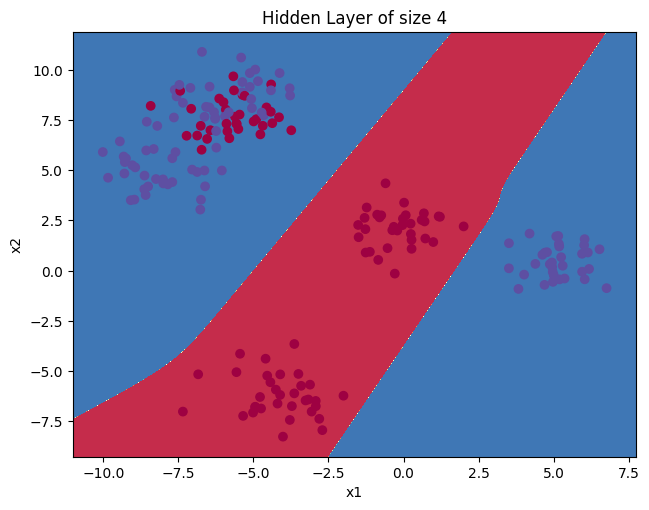

[[ 66  34]
 [  0 100]]


<Figure size 640x480 with 0 Axes>

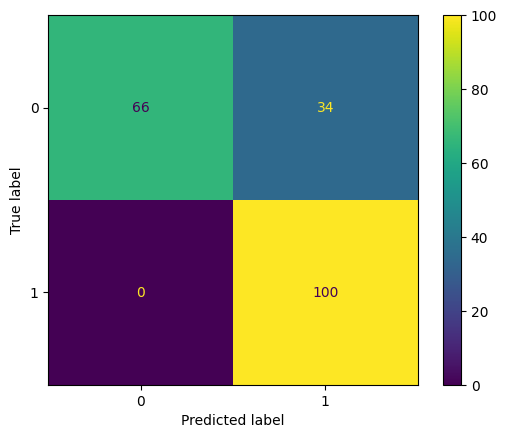

Accuracy for 4 hidden units: 83.0 %
Cost after iteration 0: 0.693478
Cost after iteration 1000: 0.238254
Cost after iteration 2000: 0.236005
Cost after iteration 3000: 0.234595
Cost after iteration 4000: 0.234435
Cost after iteration 5000: 0.233721
Cost after iteration 6000: 0.233813
Cost after iteration 7000: 0.233619
Cost after iteration 8000: 0.233471
Cost after iteration 9000: 0.233367


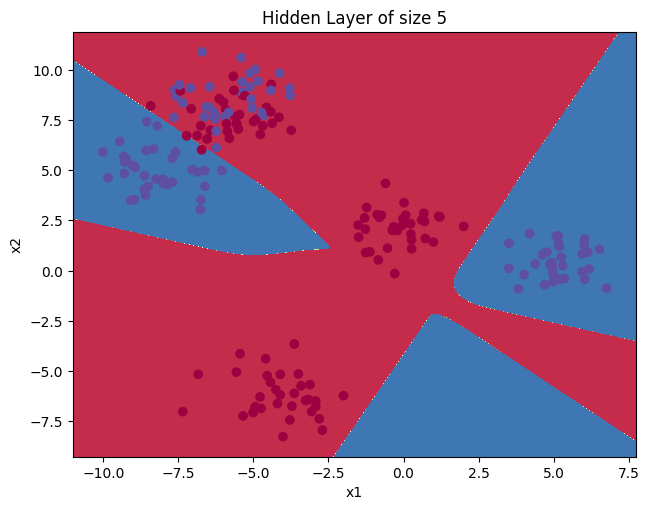

[[99  1]
 [33 67]]


<Figure size 640x480 with 0 Axes>

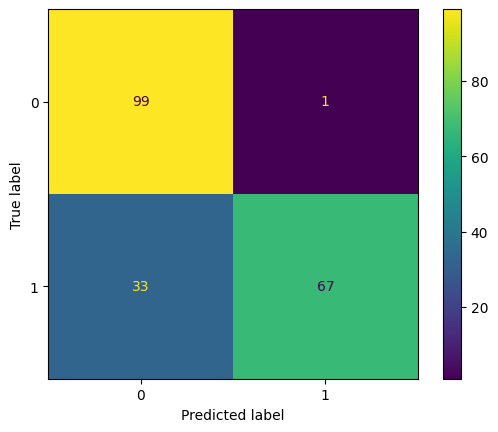

Accuracy for 5 hidden units: 83.0 %
Cost after iteration 0: 0.692967
Cost after iteration 1000: 0.226904
Cost after iteration 2000: 0.228493
Cost after iteration 3000: 0.252155
Cost after iteration 4000: 0.227142
Cost after iteration 5000: 0.208352
Cost after iteration 6000: 0.205160
Cost after iteration 7000: 0.215576
Cost after iteration 8000: 0.197447
Cost after iteration 9000: 0.191841


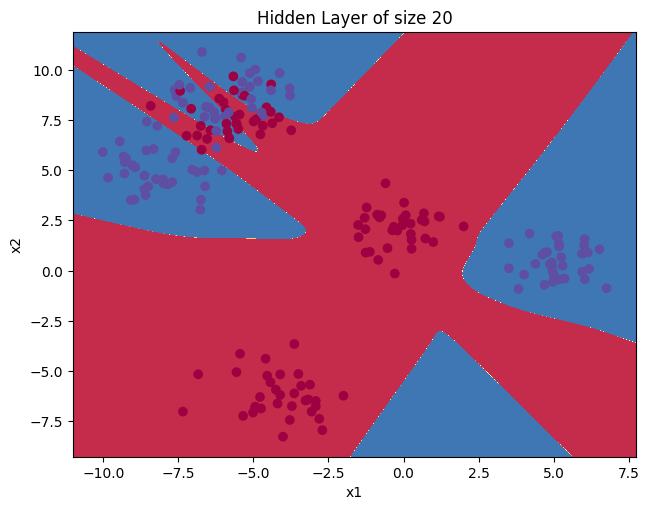

[[87 13]
 [ 7 93]]


<Figure size 640x480 with 0 Axes>

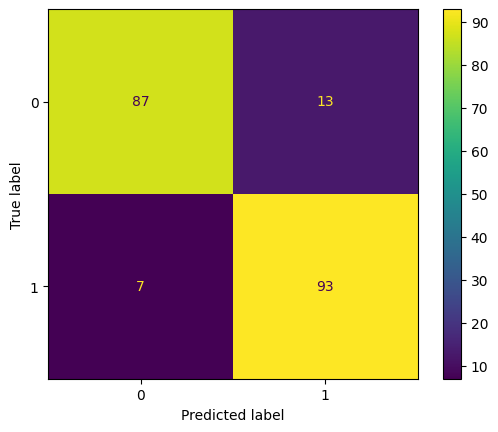

Accuracy for 20 hidden units: 90.0 %
Cost after iteration 0: 0.692765
Cost after iteration 1000: 0.243185
Cost after iteration 2000: 0.238298
Cost after iteration 3000: 0.234275
Cost after iteration 4000: 0.226367
Cost after iteration 5000: 0.229886
Cost after iteration 6000: 0.228549
Cost after iteration 7000: 0.226979
Cost after iteration 8000: 0.225005
Cost after iteration 9000: 0.220212


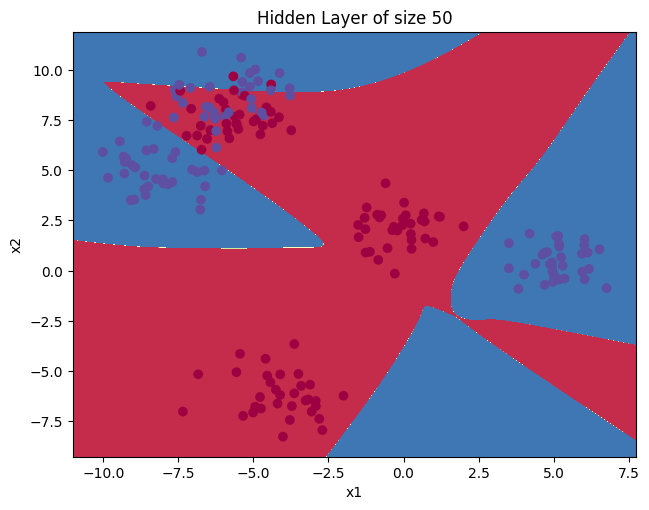

[[98  2]
 [21 79]]


<Figure size 640x480 with 0 Axes>

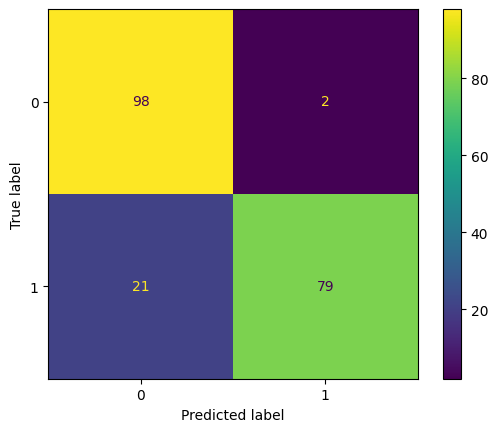

Accuracy for 50 hidden units: 88.5 %


In [36]:
#   CAMBIAR DE Datasets y REPETIR TODO EL CICLO

noisy_circles, noisy_moons, blobs = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs}

list_data = list(datasets.keys())
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

### (choose your dataset)

for dataset in list_data:

    print(f'Dataset: {dataset}')
    X, Y = datasets[dataset]
    print(Y.shape)
    X, Y = X.T, Y.reshape(1, Y.shape[0])

    # make blobs binary
    if dataset == "blobs":
        Y = Y%2

    # Visualize the data
    plt.figure()
    plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
    plt.show()
    plt.close()
    # CAMBIAMOS DE CANTIDAD DE UNIDADES OCULTAS

    for i, n_h in enumerate(hidden_layer_sizes):

        plt.figure(figsize=(16, 32))
        plt.subplot(5, 2, i+1)
        plt.title('Hidden Layer of size %d' % n_h)

        # definimos la red neuronal y la entrenamos
        parameters = nn_model(X, Y, n_h, num_iterations = 10000, print_cost = True)
        plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
        plt.show()
        plt.close()

        # a ver qué tanto acierta...
        predictions = predict(parameters, X)

        # matriz de confusión
        matriz_confusion(Y.flatten(), predictions.flatten())

        # procentaje de aciertos
        accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
        print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
